In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import argparse
from pathlib import Path
from omegaconf import OmegaConf
from datetime import datetime
from torch_geometric.data import Data
import pandapower as pp
import networkx as nx
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

# sys.path.append(str(Path(__file__).parents[1]))
from scripts.arquitecturas import GNN_global, FCNN_global, GNN_Local
from scripts.Data_loader import load_net, load_data
from scripts.metric import NormalizedError
from scripts.train_eval import run_epoch, evaluate

import warnings
warnings.filterwarnings('ignore')

# Load config  /home/iboero/Documents/GNN4OPF/Entrenar/runs/118/GNN_local/05-06_17:33:20
dt = "05-06_17:33:20"
cfg = OmegaConf.load("./runs/118/GNN_local/" + dt + "/config.yaml")
weights_dir = "./runs/118/GNN_local/" + dt + "/weights/best_model.pt"



# Set device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Set network
num_nodes, num_gens, edge_index, edge_weights, feature_mask, net= load_net(cfg.data.red,device)

# Set model
if cfg.model.model == 'GNN_global':
    model = GNN_global(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,num_nodes,num_gens, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_global':
    # Add in and out dimension
    cfg.model.layers[0] *= num_nodes
    model = FCNN_global(cfg.model.layers,len(cfg.model.layers)-1,num_nodes, feature_mask, cfg.model.batch_norm).to(device)
elif cfg.model.model == 'GNN_local':
    model = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)
elif cfg.model.model == 'FCNN_local':
    K = [0 for i in range(len(cfg.model.layers)-1)]
    model = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,K,feature_mask,num_nodes,cfg.model.batch_norm).to(device)

# Load data
train_loader, val_loader, test_loader = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.normalize_Y,device)

# Cargo los pesos al modelo guardados en weights_dir +weights.pt
model.load_state_dict(torch.load(weights_dir))

<All keys matched successfully>

In [3]:
import pandapower as pp
import pandapower.networks as nw
from copy import deepcopy
import pandapower.plotting as plot
import numpy as np
import pandas as pd
import os
import numba

import julia
julia.install()

from julia.api import Julia
jl = Julia(compiled_modules=False)

import warnings
warnings.filterwarnings('ignore')

import argparse

[ Info: Julia version info


Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      "Manjaro Linux"
  uname: Linux 6.6.26-1-MANJARO #1 SMP PREEMPT_DYNAMIC Wed Apr 10 20:11:08 UTC 2024 x86_64 unknown
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4500 MHz     328218 s     340357 s     101016 s   43046078 s      15656 s
       
  Memory: 62.63359451293945 GB (1579.0859375 MB free)
  Uptime: 276233.0 sec
  Load Avg:  2.47  1.35  1.17
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, goldmont)
Environment:
  HOME = /home/iboero
  PATH = /home/iboero/miniconda3/envs/proy/bin:/home/iboero/.vscode-server/cli/servers/Stable-b58957e67ee1e712cebf466b995adf4c5307b2bd/server/bin/remote-cli:/home/iboero/miniconda3/envs/proy/bin:/home/iboero/miniconda3/condabin:/home/iboero/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/nsi

[ Info: Julia executable: /home/iboero/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
│     libpython: /home/iboero/miniconda3/envs/proy/lib/libpython3.11.so.1.0
│ Python:
│     python: /home/iboero/miniconda3/envs/proy/bin/python
└     libpython: 


In [4]:
x_0, y_0 = next(iter(train_loader))

# idx = 19

# x_0_i = x_0[idx].unsqueeze(0)
# y_0_i = y_0[idx].unsqueeze(0)
net = pp.networks.case118()

In [5]:
def ploss_metric(net, X, y):
    X_np = X.clone().detach().cpu().numpy()
    y_np = y.clone().detach().cpu().numpy()
    loss = []
    for i in range(X.shape[0]):
        net.load.loc[:,'p_mw'] = X_np[i,net.load["bus"].to_list(),0]
        net.load.loc[:,'q_mvar'] = X_np[i,net.load["bus"].to_list(),1]
        net.gen.loc[:,'p_mw'] =  X_np[i,net.gen["bus"].to_list(),2]
        net.gen.loc[:,'vm_pu'] =  y_np[i,net.gen["bus"].to_list(),0]
        pp.runpp(net, numba=False)
        loss.append(net.res_line.pl_mw.sum())
    return loss




In [6]:
y_0_pred = model(x_0)

In [7]:
print(y_0_pred[0][net.gen["bus"].to_list()])



tensor([[1.0330],
        [1.0615],
        [1.0508],
        [1.0401],
        [1.0581],
        [1.0527],
        [1.0478],
        [1.0482],
        [1.0461],
        [1.0357],
        [1.0588],
        [1.0311],
        [1.0206],
        [1.0213],
        [1.0209],
        [1.0532],
        [1.0488],
        [1.0338],
        [1.0175],
        [1.0229],
        [1.0313],
        [1.0213],
        [1.0223],
        [1.0204],
        [1.0499],
        [1.0498],
        [1.0407],
        [1.0312],
        [1.0561],
        [1.0207],
        [1.0255],
        [1.0302],
        [0.9945],
        [0.9845],
        [1.0315],
        [1.0541],
        [1.0411],
        [1.0591],
        [1.0598],
        [1.0402],
        [1.0480],
        [1.0453],
        [1.0516],
        [1.0534],
        [1.0489],
        [1.0396],
        [1.0352],
        [1.0352],
        [1.0386],
        [1.0465],
        [1.0356],
        [1.0474],
        [1.0437]], device='cuda:0', grad_fn=<IndexBackward0>)


In [8]:
y_0[0]

tensor([[1.0322],
        [0.0000],
        [0.0000],
        [1.0600],
        [0.0000],
        [1.0530],
        [0.0000],
        [1.0379],
        [0.0000],
        [1.0530],
        [0.0000],
        [1.0536],
        [0.0000],
        [0.0000],
        [1.0504],
        [0.0000],
        [0.0000],
        [1.0539],
        [1.0501],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0403],
        [1.0600],
        [1.0346],
        [1.0193],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0266],
        [1.0229],
        [0.0000],
        [1.0539],
        [0.0000],
        [1.0522],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0322],
        [0.0000],
        [1.0214],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0102],
        [0.0000],
        [0.0000],
        [1.0252],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0146],
        [1.0187],
        [1

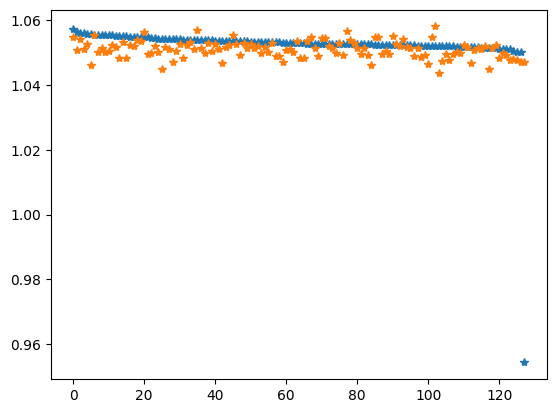

In [9]:
# Ordeno de mayor a menor y_0[:,0,0]

bus = 11
idx = torch.argsort(y_0[:,bus,0],descending=True)
y_0_ord = y_0[idx,bus,0].detach().cpu().numpy()
y_0_pred_ord = y_0_pred[idx,bus,0].detach().cpu().numpy()

import matplotlib.pyplot as plt
plt.plot(y_0_ord,  "*")
plt.plot(y_0_pred_ord, "*")
plt.show()

In [10]:
# Concateno todos los datos de train loader
X_train = torch.cat([x for x, y in train_loader])
# Mismo para y
y_train = torch.cat([y for x, y in train_loader])
y_pred = model(X_train)

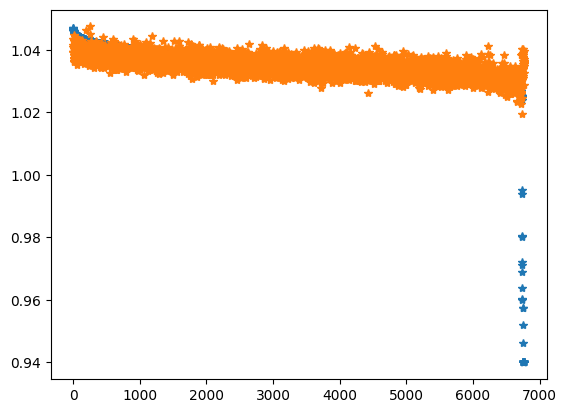

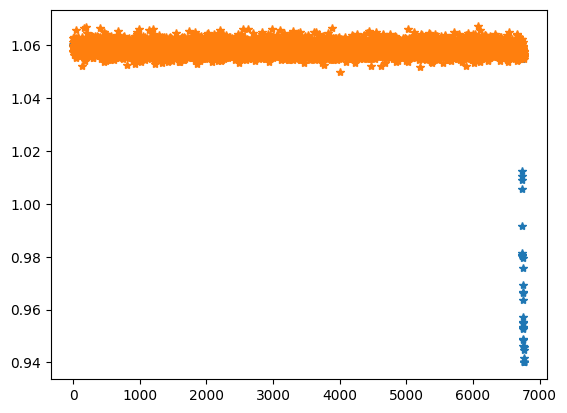

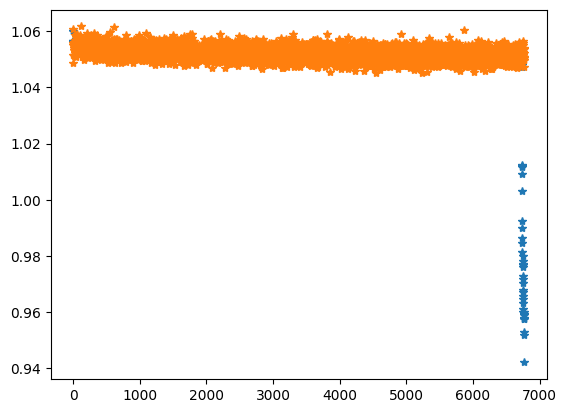

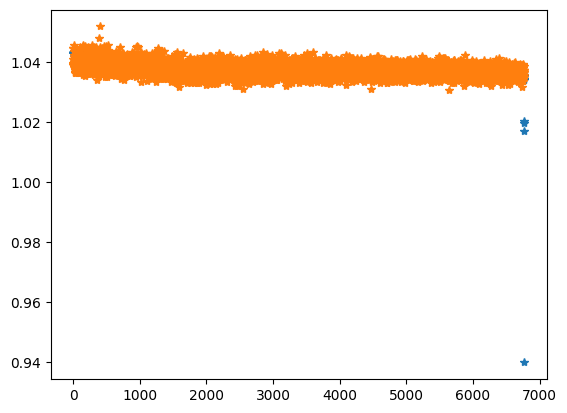

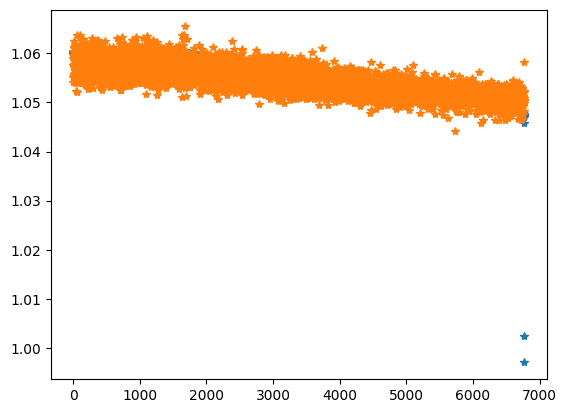

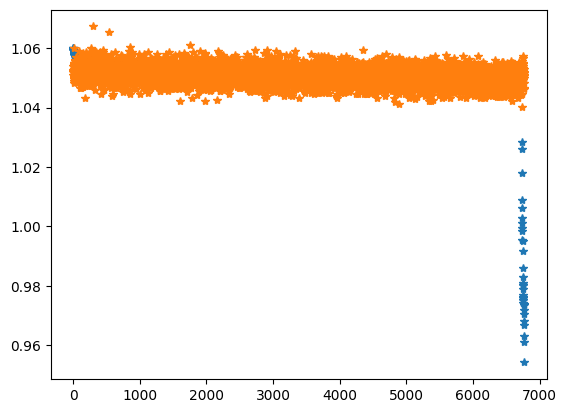

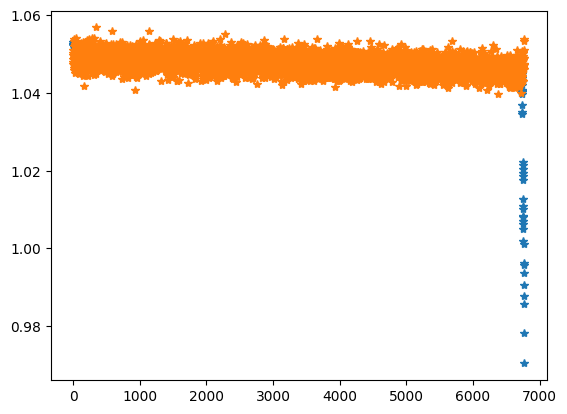

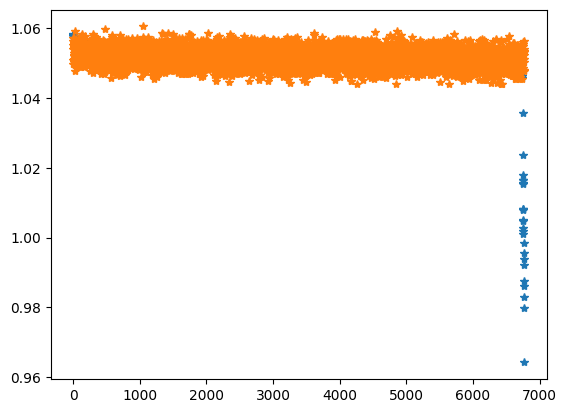

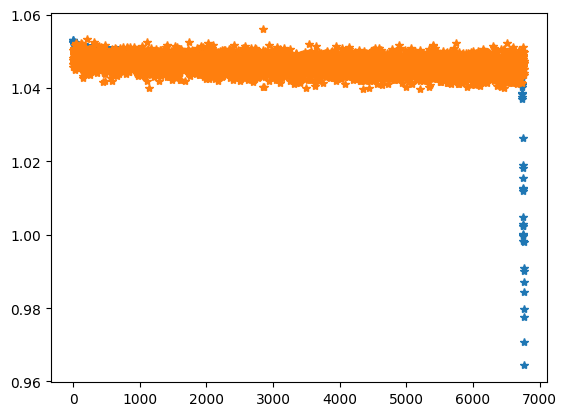

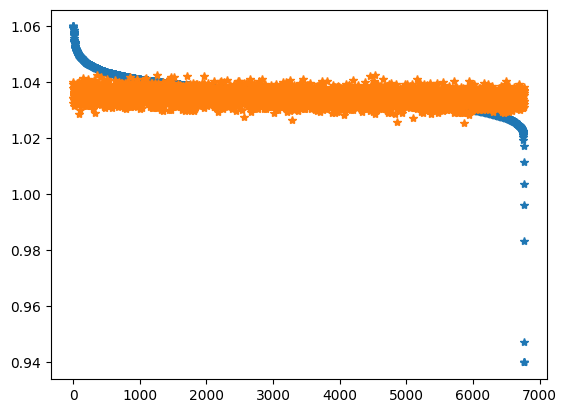

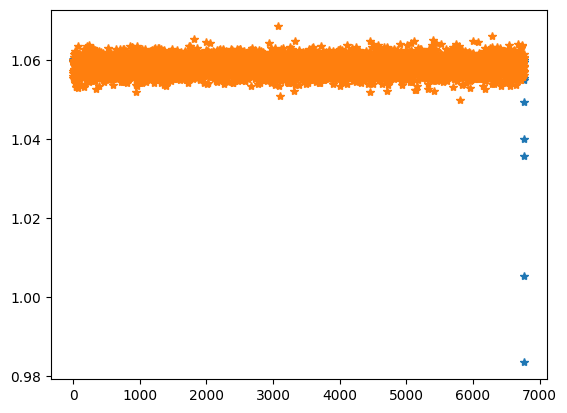

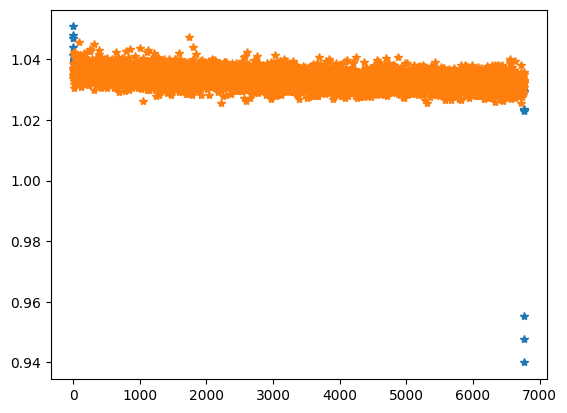

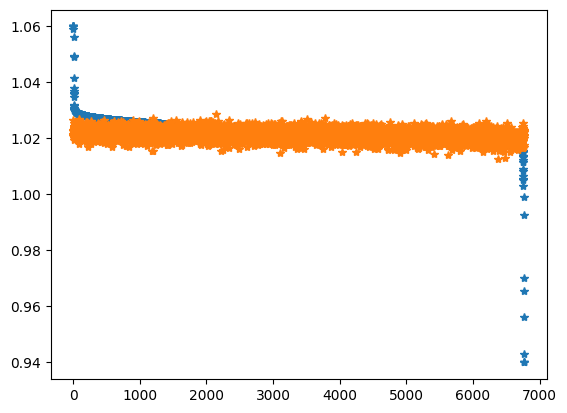

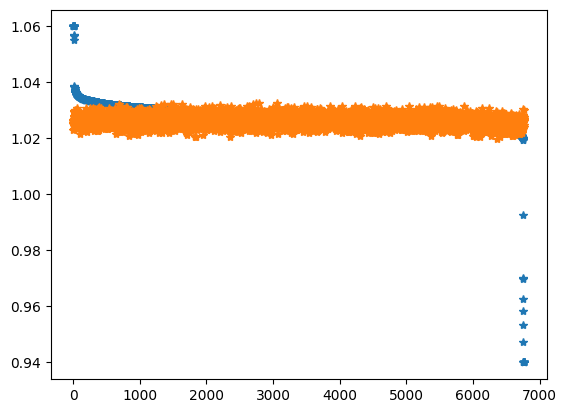

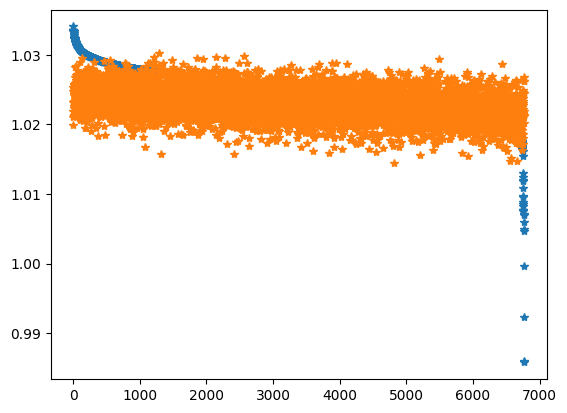

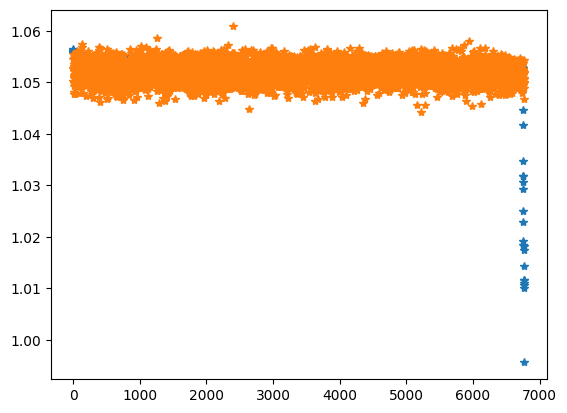

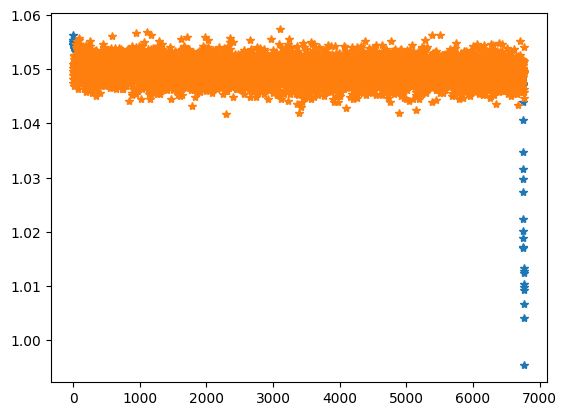

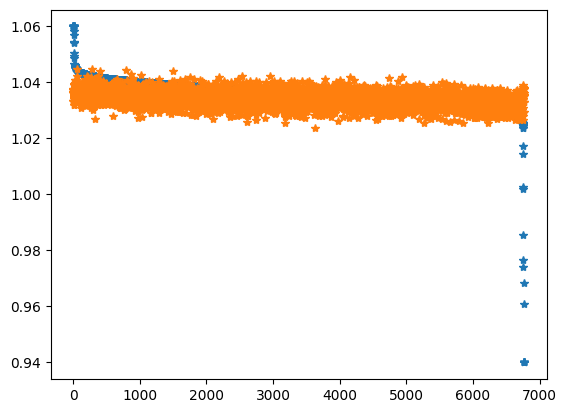

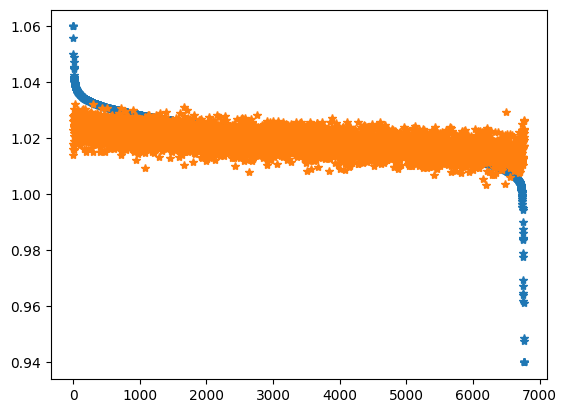

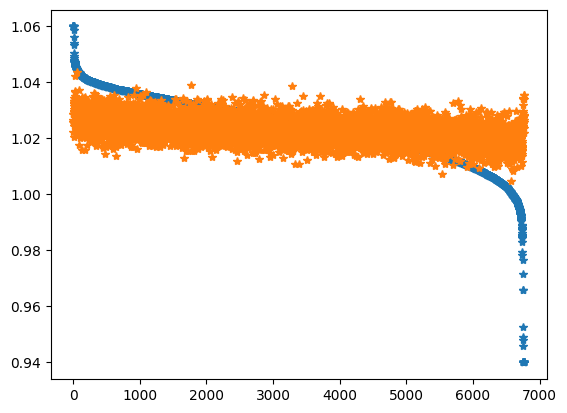

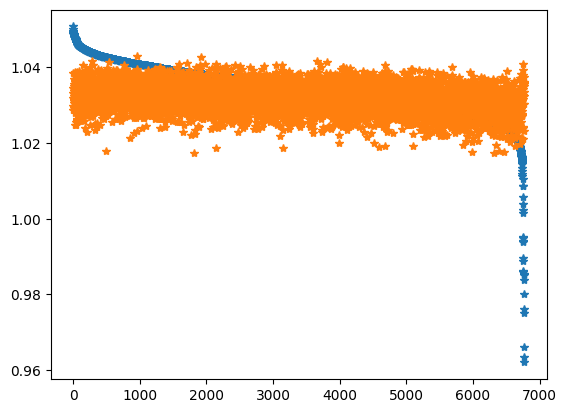

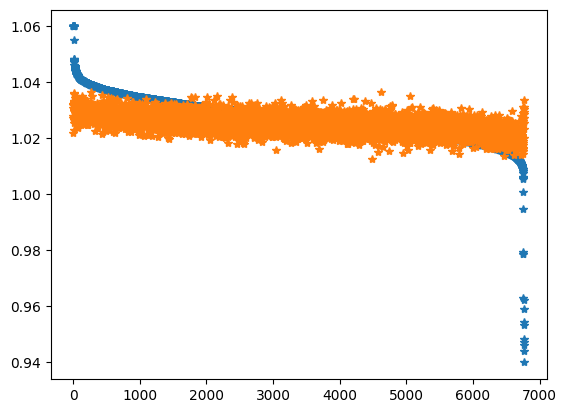

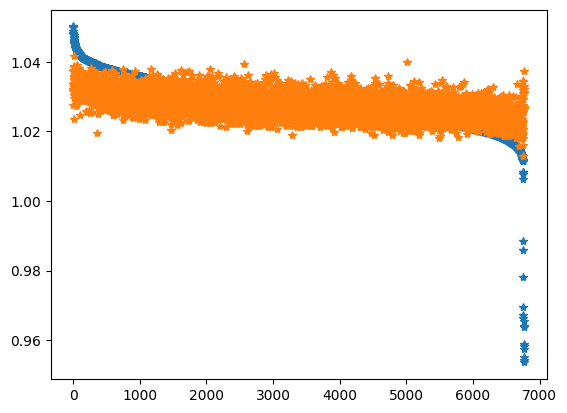

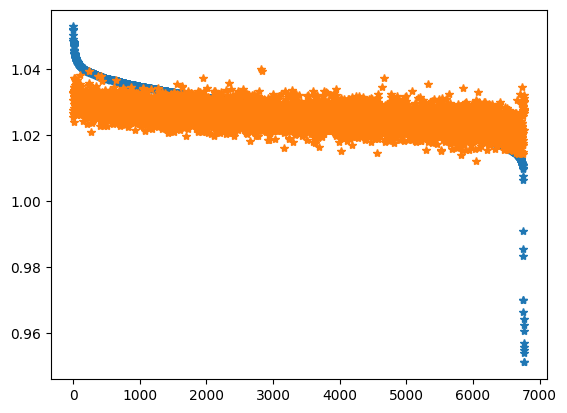

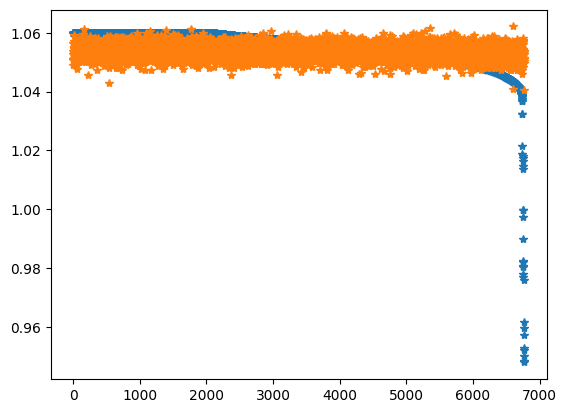

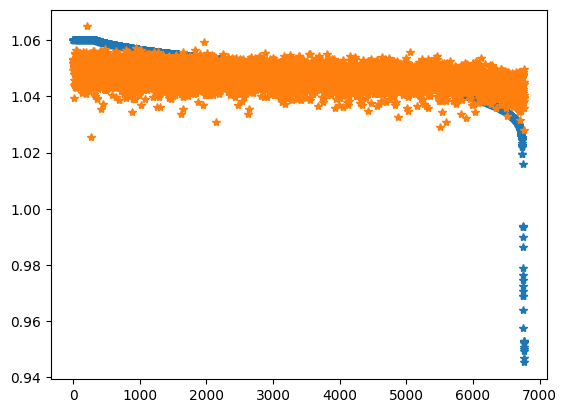

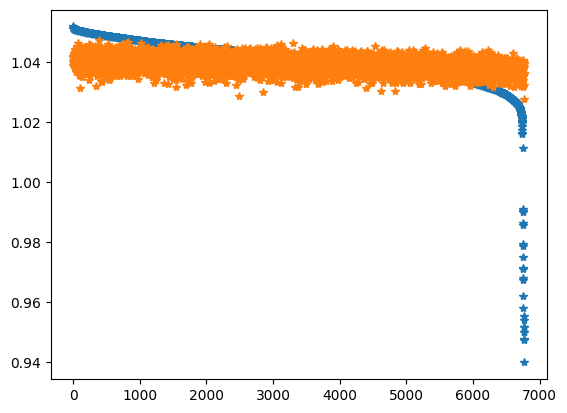

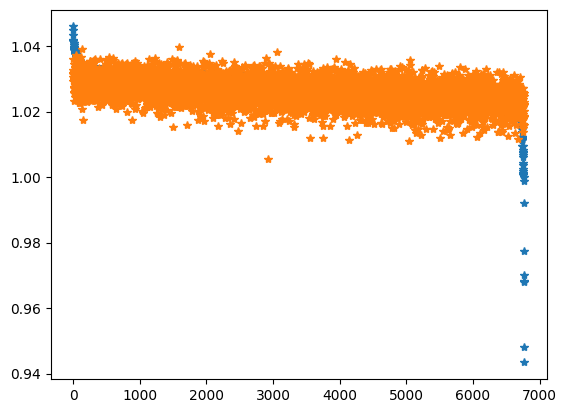

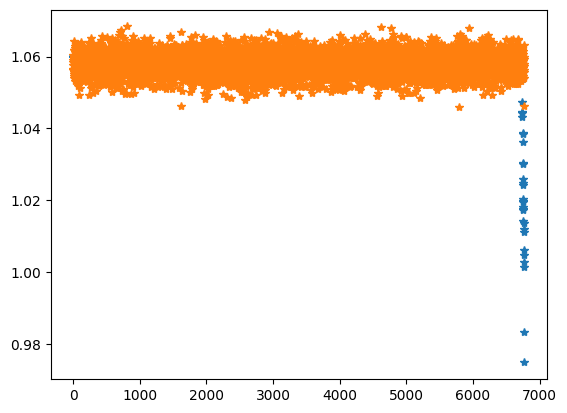

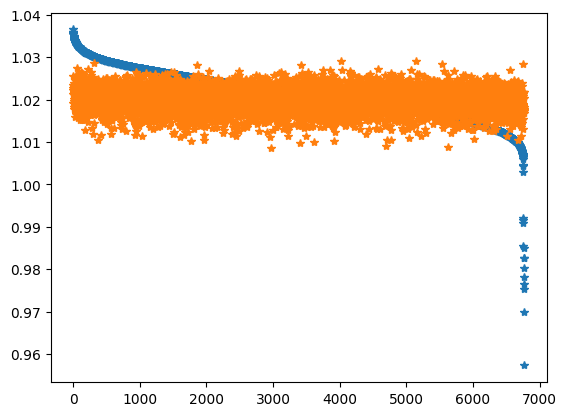

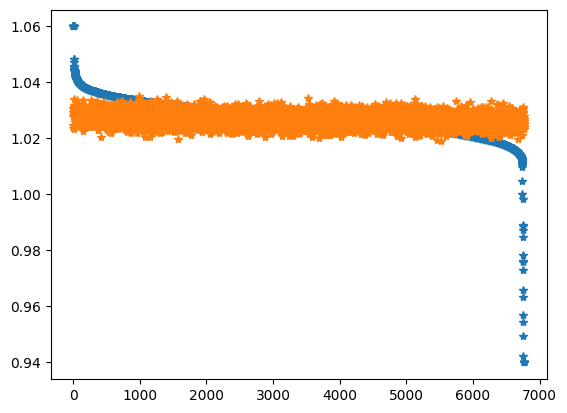

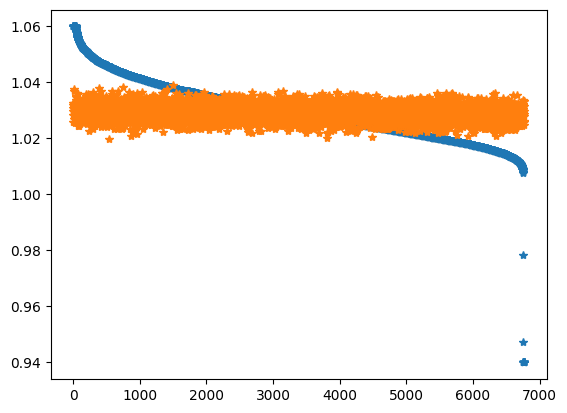

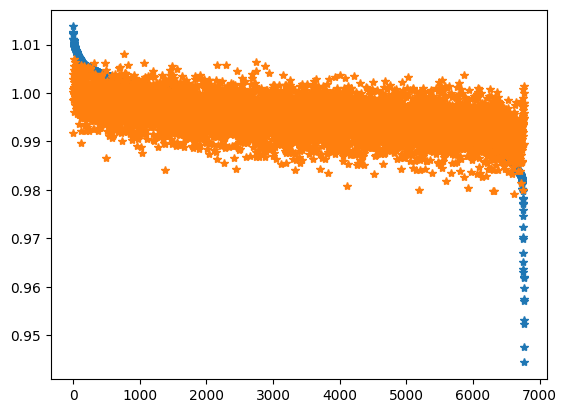

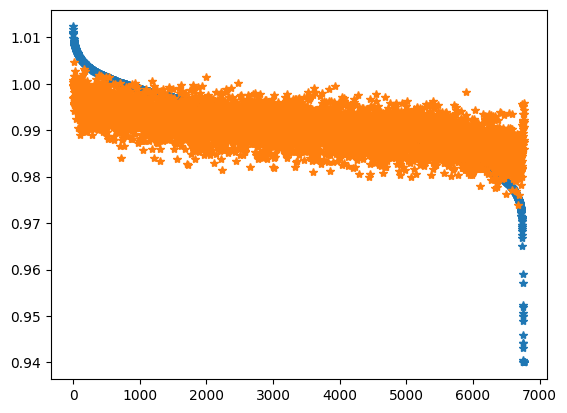

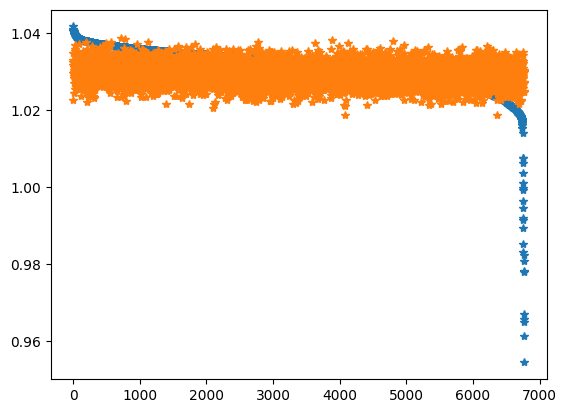

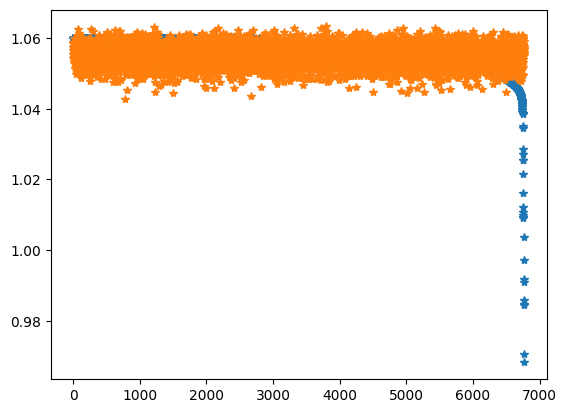

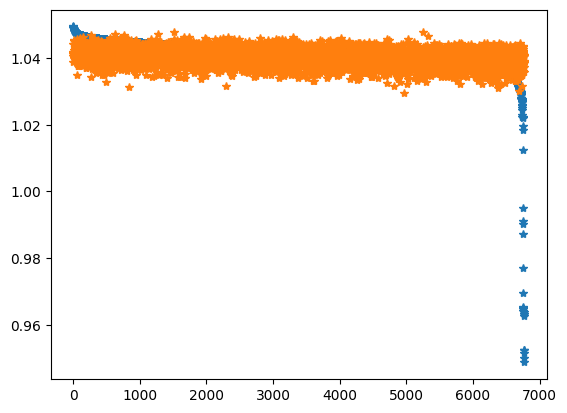

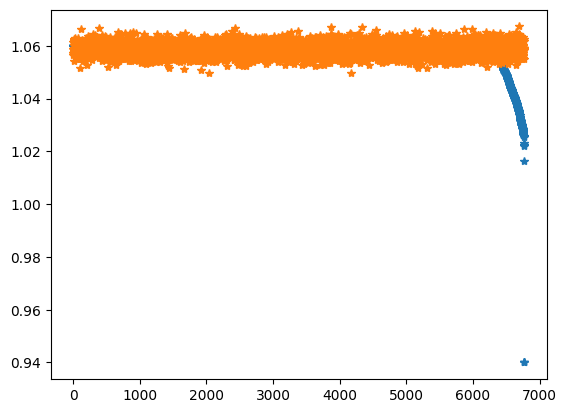

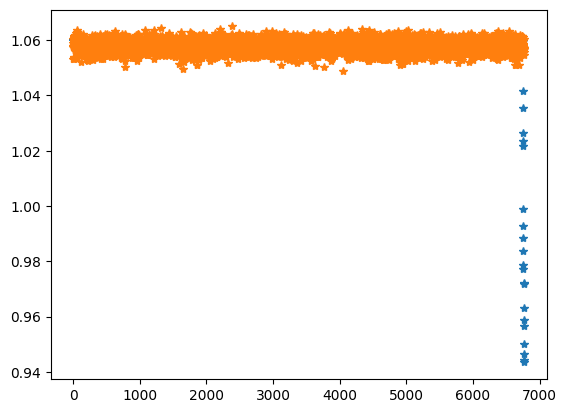

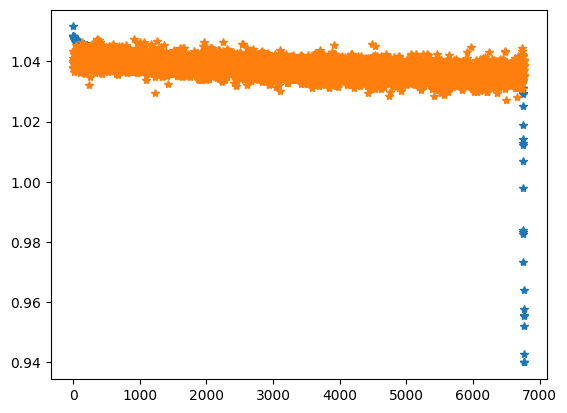

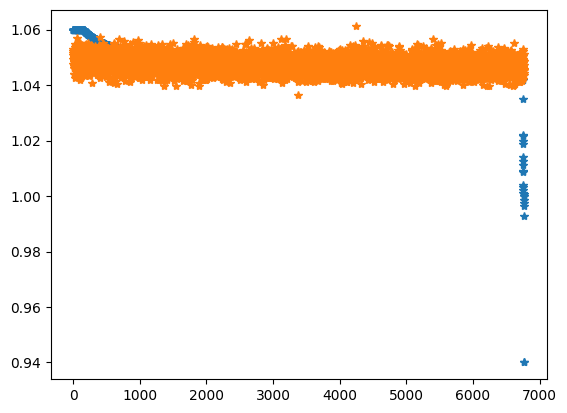

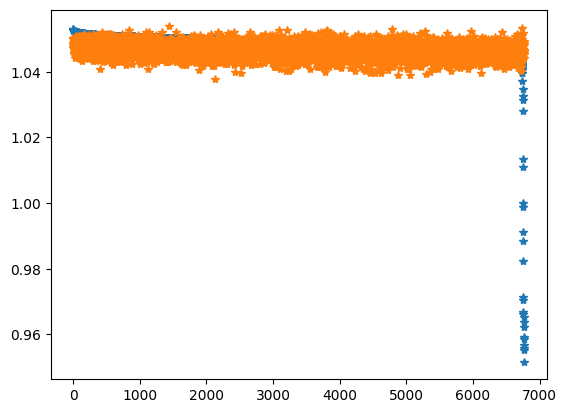

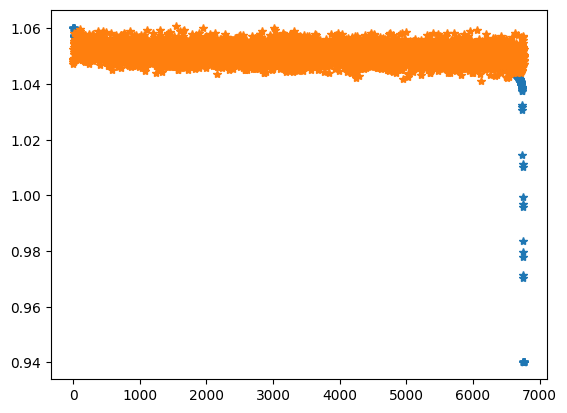

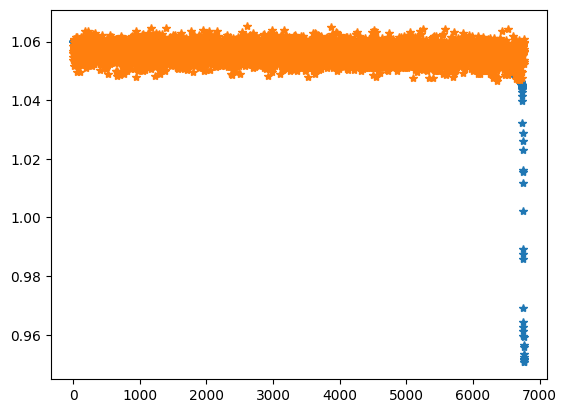

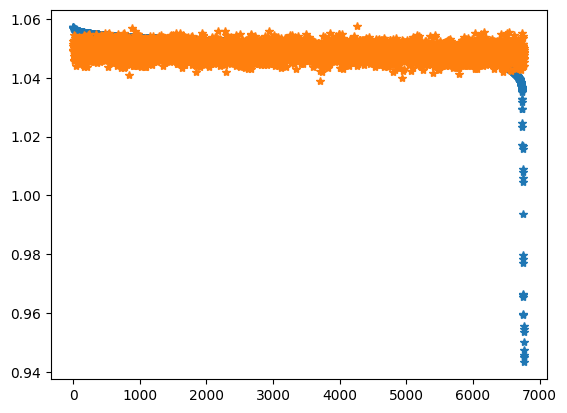

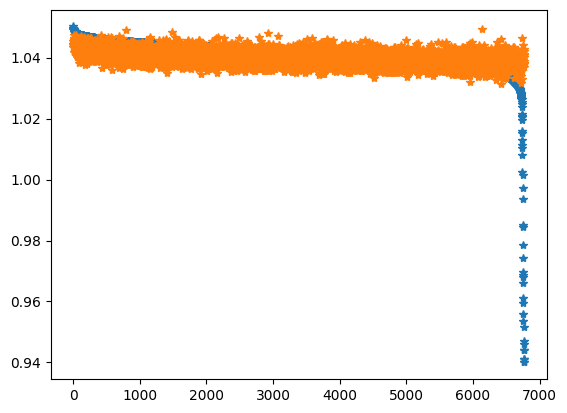

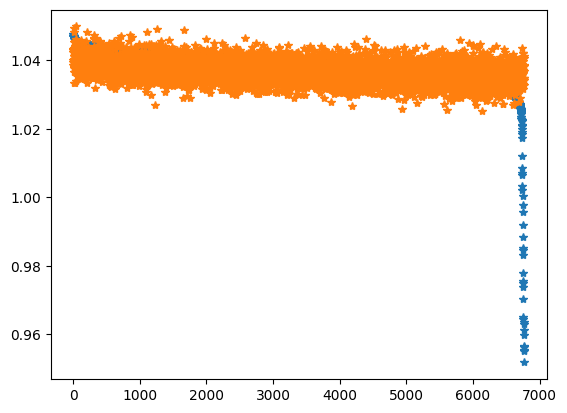

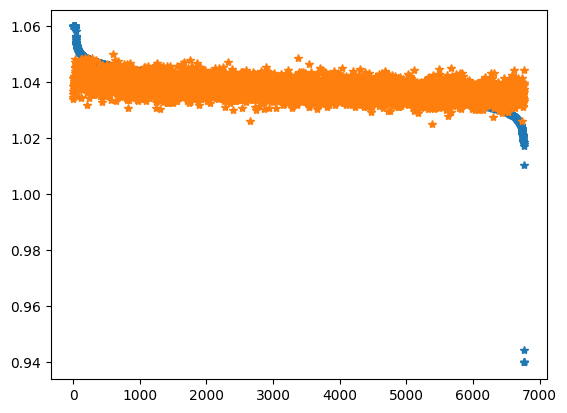

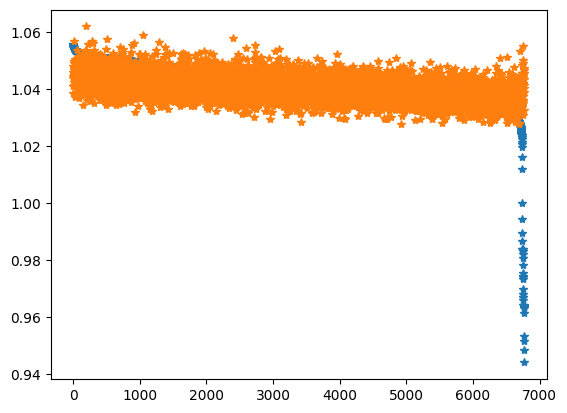

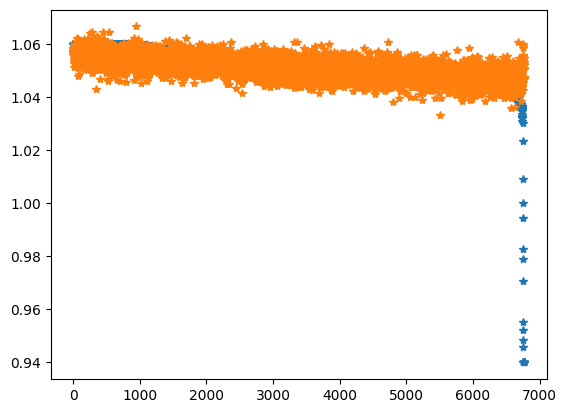

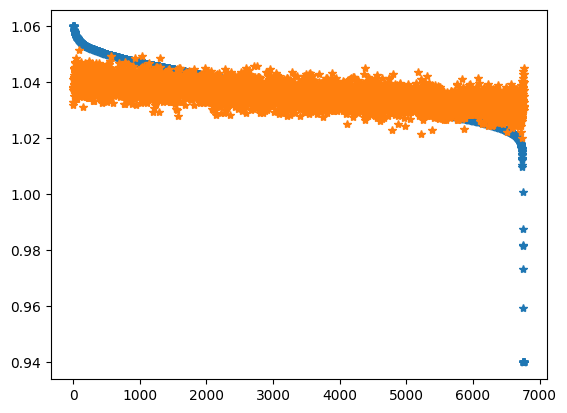

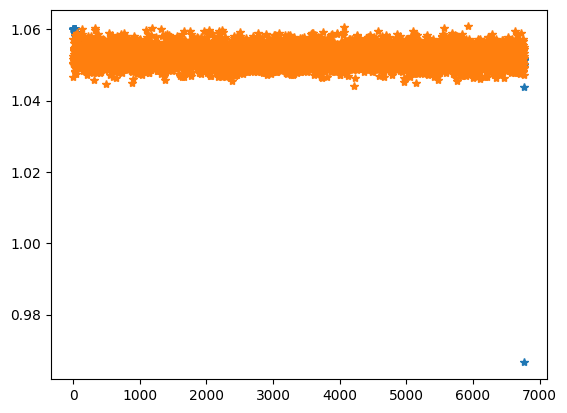

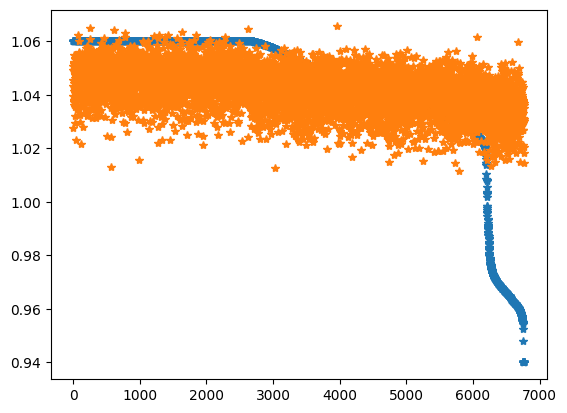

In [13]:


for bus in net.gen["bus"]:
    idx = torch.argsort(y_train[:,bus,0],descending=True)
    y_train_ord = y_train[idx,bus,0].detach().cpu().numpy()
    y_pred_ord = y_pred[idx,bus,0].detach().cpu().numpy()

    import matplotlib.pyplot as plt
    plt.plot(y_train_ord,  "*")
    plt.plot(y_pred_ord, "*")
    plt.show()

